In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_orig = pd.read_stata("/home/kavi/gss7221_r2.dta", convert_categoricals=False)

In [3]:
data = data_orig

In [4]:
data = data[data["age"] <= 35]

In [5]:
data = data[~np.isnan(data["sexfreq"])]

In [6]:
data = data[~np.isnan(data["sex"])]

In [7]:
years = sorted(set(data.year) - {2012})

In [8]:
def compute(year, sex, do_weight):
    rel = data[(data.year == year) & (data.sex == sex)]
    weight = rel.wtssnrps if year == 2021 else rel.wtss
    var = rel.sexfreq == 0
    weight,var = np.array(weight), np.array(var)
    if not do_weight:
        weight = np.ones_like(weight)
    boot_idxs = np.random.RandomState(0).choice(var.shape[0], (10_000, var.shape[0]), replace=True)
    boot_distro = (var[boot_idxs] * weight[boot_idxs]).sum(-1) / weight[boot_idxs].sum(-1)
    lo, hi = np.percentile(boot_distro, 2.5), np.percentile(boot_distro, 97.5)
    return (var * weight).sum() / weight.sum(), lo, hi

In [9]:
def plot(sex, name, color, do_weight):
    results = np.array([compute(year, sex, do_weight) for year in years]) * 100
    plt.plot(years, results[:,0], label=name, color=color)
    plt.fill_between(years, results[:,1], results[:,2], color=color, alpha=0.25)


In [10]:
def full_plot(do_weight):
    plt.figure(dpi=200, facecolor="white")
    plt.title("GSS Data on Under 35s [shaded is 95% bootstrap CI] " + ("(no weighting)" * (not do_weight)))
    plot(1, "Men", "blue", do_weight)
    plot(2, "Women", "#c80", do_weight)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Reported no sex in last year [%]")
    plt.xticks(years, years, rotation=90)
    plt.ylim(0, 40)
    plt.show()

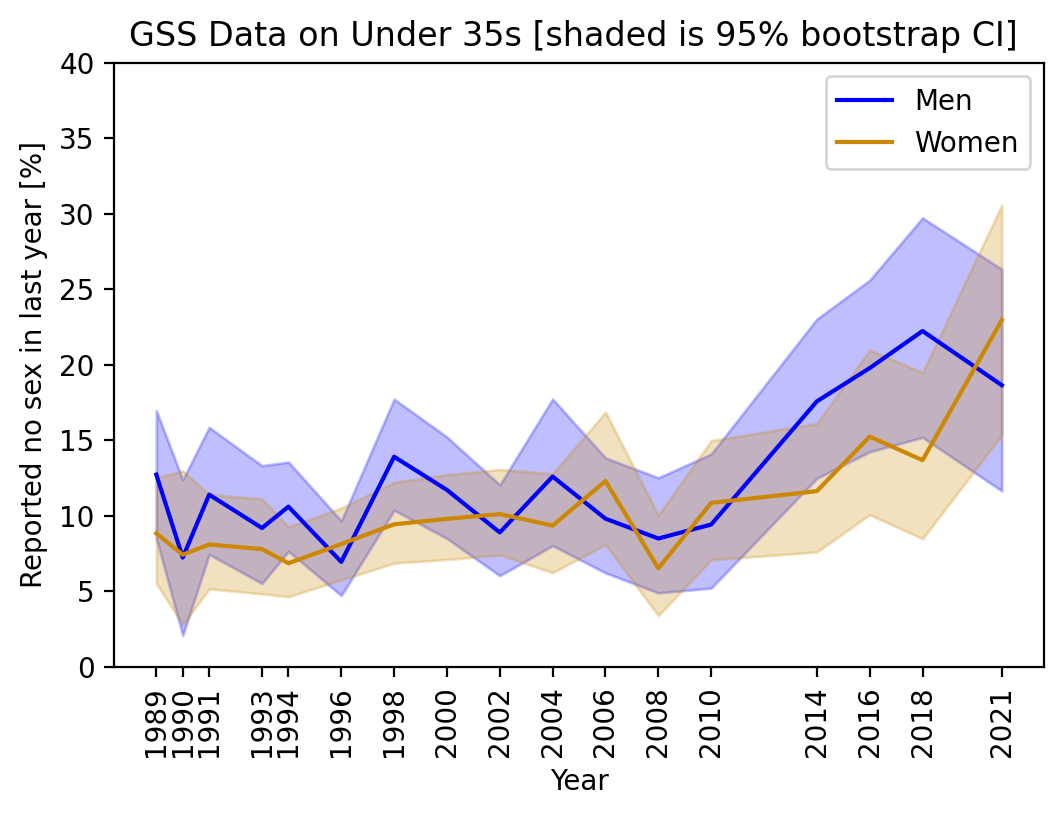

In [11]:
full_plot(True)

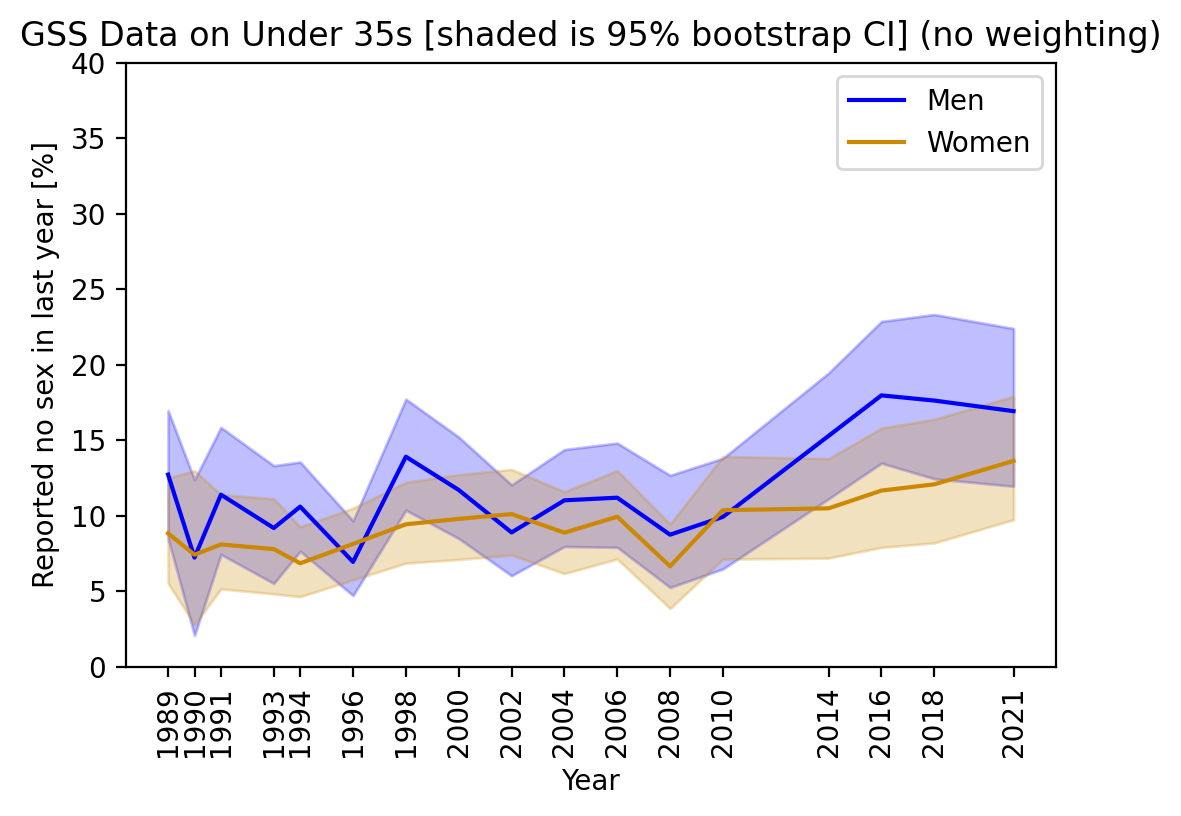

In [12]:
full_plot(False)